# Stroke Risk Assessment: Developing a Machine Learning Tool to Predict Patient Outcomes from Clinical Features

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
from scipy.stats import skew, kurtosis, shapiro

# Import classifiers
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier

# Import unsupervised learning libraries
# import sklearn.feature_extraction
import sklearn.cluster
from sklearn.decomposition import PCA 

# Import evaluation libraries
import sklearn.metrics as skmetrics
from sklearn.model_selection import learning_curve  # Learning curve
from sklearn.inspection import permutation_importance  # Permutation-based feature importance


In [3]:
# Load the data
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Display data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# Calculate summary statistics of numerical columns
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Data preprocessing

First, for every method we apply to the data, we create a copy to avoid modifying the original. After that, the first step we take is to remove the "id" column as it is a feature of no predictive importance.

In [6]:
# Drop the id column
data.drop('id', axis=1, inplace=True)

Next, we check if the dataset has any duplicate or missing values.

In [7]:
# Check for duplicate values
data.duplicated().sum()

0

In [8]:
# Check for missing values
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Examining the "bmi" column reveals that there are 201 missing values. There are several strategies at our disposal to address this. We can impute the missing values of `bmi` using the **median** (if the data is skewed) or the **mean** (if the data is relatively normally distributed), or we could remove rows with missing values entirely. We will examine the distribution of the 'bmi' column to determine which to use.

A word on removing rows: this is a straightforward approach but could potentially bias the data if the values are not *missing at random* (e.g. if the values are missing for certain types of patients). It would also reduce the size of the dataset. We will also examine what happens if we remove the rows and how that might affect performance.

Let us first examine the distribution of the 'bmi' column. We will generate descriptive statistics, plot a histogram and boxplot to visualize the distribution and outliers, and also perform formal statistical tests for distribution skewness, kurtosis, and normality.

In [9]:
# Generate descriptive statistics for the 'bmi' column
bmi_stats = data['bmi'].describe()
bmi_stats

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

In [10]:
# Calculate and display the number of missing values in the BMI column
missing_bmi_count = data['bmi'].isnull().sum()
missing_bmi_count

201

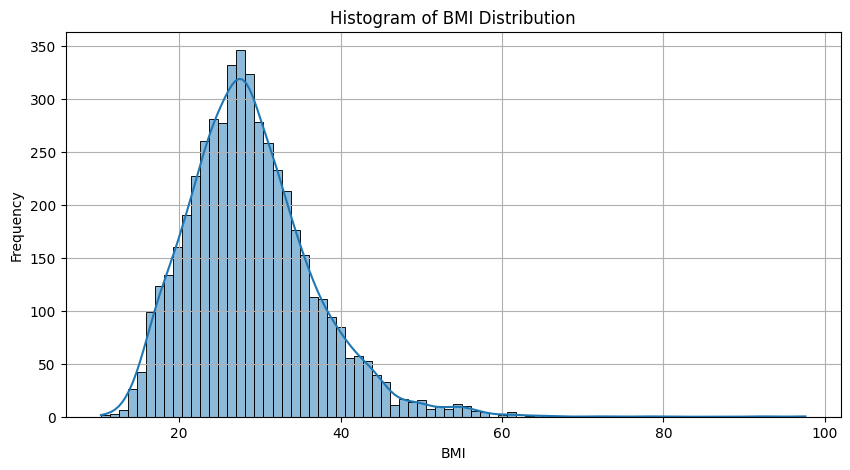

In [11]:
# Plot a histogram of the 'bmi' column
plt.figure(figsize=(10, 5))
sns.histplot(data['bmi'], kde=True)  # Plot a histogram of the 'bmi' column with a kernel density estimate for the distribution
plt.title('Histogram of BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

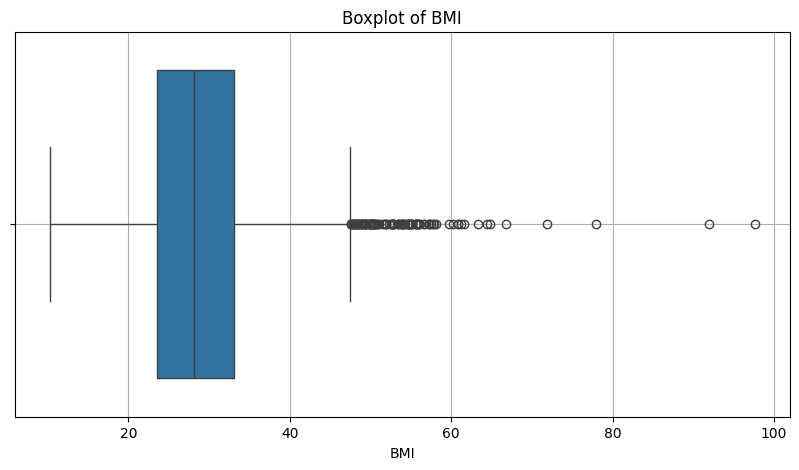

In [12]:
# Visualize outliers with a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['bmi'])
plt.title('Boxplot of BMI')
plt.xlabel('BMI')
plt.grid(True)
plt.show()

In [13]:
# Determine distribution of the 'bmi' column
bmi_values = data['bmi'].dropna()  # Removing missing values for accurate statistics

# Calculate skewness and kurtosis
bmi_skewness = skew(bmi_values)
bmi_kurtosis = kurtosis(bmi_values)

# Perform the Shapiro-Wilk test for normality
shapiro_test = shapiro(bmi_values)

print(f"Skewness: {bmi_skewness}")
print(f"Kurtosis: {bmi_kurtosis}")
print("Shapiro-Wilk test statistic:", shapiro_test.statistic, "p-value:", shapiro_test.pvalue)

Skewness: 1.0550177068872404
Kurtosis: 3.3580131522730943
Shapiro-Wilk test statistic: 0.9535468320743545 p-value: 6.615876600227794e-37


A skewness of 1.055 indicates that the distribution of 'bmi' has a tail extending to the right. A kurtosis value of 3.36 (compared to a normal distribution's value of 3) indicates that the distribution has heavier tails and a sharper peak than a normal distribution. Finally, the Shapiro-Wilk test returning a p-value of almost zero indicates that we should reject the null hypothesis that the distribution is normal. In conclusion, there is little doubt that the 'bmi' distribution is skewed, and as such, we should use the **median** to impute its missing values.

In [14]:
# Impute the missing values of 'bmi' with the median of the column
bmi_median = data['bmi'].median()
data.fillna({'bmi': bmi_median}, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [15]:
# Double check for missing values
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Since the dataset contains both numerical and categorical features, and since we want to keep all predictive features in the same dataset, we first track which columns are numerical and categorical. We scale our numerical features by standardizing our data to prevent any feature exerting undue influence on the model. This is particularly important in SVC, because it depends on calculating the distances between points. We also encode our categorical features by mapping them to numerical values since the model deals only with numbers.

In [16]:
# Identify categorical and numerical columns
numerical_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [17]:
# Standardize the numerical columns
print("Numerical columns:", numerical_cols)
data[numerical_cols[:-1]] = StandardScaler().fit_transform(data[numerical_cols[:-1]])  # Exclude the target column ("stroke")

Numerical columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


In [18]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5110.000000
mean,5.005781e-17,-4.727682e-17,5.561978e-18,1.001156e-16,-4.449583e-17,0.048728
std,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,1.000098e+00,0.215320
min,-1.908261e+00,-3.286019e-01,-2.389468e-01,-1.126958e+00,-2.411027e+00,0.000000
25%,-8.061152e-01,-3.286019e-01,-2.389468e-01,-6.383223e-01,-6.575089e-01,0.000000
50%,7.843218e-02,-3.286019e-01,-2.389468e-01,-3.149945e-01,-9.898092e-02,0.000000
75%,7.860701e-01,-3.286019e-01,-2.389468e-01,1.754080e-01,5.115031e-01,0.000000
max,1.714845e+00,3.043196e+00,4.185032e+00,3.657145e+00,8.928390e+00,1.000000


Next, since most classification algorithms work with numerical data, we need to convert the categorical features to numbers.

In [19]:
# Remind ourselves of the categorical columns
print("Categorical columns:", categorical_cols)

Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [20]:
# Examine the gender column
data.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [21]:
# Drop the outlier value for simplicity
data.drop(data[data.gender == "Other"].index, inplace=True)  # Drop the row with the outlier value
data.reset_index(drop=True, inplace=True)  # Reset the index after dropping the row

In [22]:
# Encode the gender column
data.gender = data.gender.map({
    "Male": 0,
    "Female": 1,
})

In [23]:
# Examine the ever_married column
data.ever_married.value_counts()

ever_married
Yes    3353
No     1756
Name: count, dtype: int64

In [24]:
# Encode the ever_married column
data.ever_married = data.ever_married.map({
    "No": 0,
    "Yes": 1,
})

In [25]:
# Examine the work_type column
data.work_type.value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [26]:
# Encode the work_type column
data.work_type = data.work_type.map({
    "Private": 0,
    "Self-employed": 1,
    "children": 2,
    "Govt_job": 3,
    "Never_worked": 4
})

In [27]:
# Examine the Residence_type column
data.Residence_type.value_counts()

Residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

In [28]:
# Encode the Residence_type column
data.Residence_type = data.Residence_type.map({
    "Urban": 0,
    "Rural": 1
})

In [29]:
# Examine the smoking_status column
data.smoking_status.value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [30]:
# Encode the smoking_status column
data.smoking_status = data.smoking_status.map({
    "never smoked": 0,
    "formerly smoked": 1,
    "smokes": 2,
    "Unknown": 3
})

We now separate the dataset into training and testing splits to prepare it for modeling. 

In [31]:
# Split the data into features and target
X = data.drop('stroke', axis=1)
y = data['stroke']
X.shape, y.shape

((5109, 10), (5109,))

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Our dataset is now ready for modeling.

## Support vector classifier (SVC)

In [33]:
# Initialize the classifier
svc_model = SVC(kernel="linear",  # Linear kernel
                probability=True)  # Enable probability estimates

# Train the classifier on the training set
svc_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [34]:
# Make predictions on the test set
y_pred = svc_model.predict(X_test)

In [35]:
# Evaluate the model
print("Confusion matrix:\n", skmetrics.confusion_matrix(y_test, y_pred))
print("Accuracy:", skmetrics.accuracy_score(y_test, y_pred))
#print("Classification report:\n", skmetrics.classification_report(y_test, y_pred))

Confusion matrix:
 [[1930    0]
 [ 114    0]]
Accuracy: 0.9442270058708415


## k-nearest neighbors classifier

In [36]:
# Initialize the classifier
knn = KNeighborsClassifier(n_neighbors=3)  # Number of neighbors: 3

# Train the classifier on the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [37]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

In [38]:
# Evaluate the model
print("Confusion matrix:\n", skmetrics.confusion_matrix(y_test, y_pred))
print("Accuracy:", skmetrics.accuracy_score(y_test, y_pred))
#print("Classification report:\n", skmetrics.classification_report(y_test, y_pred))

Confusion matrix:
 [[1910   20]
 [ 114    0]]
Accuracy: 0.9344422700587084


## Pipeline creation and performance comparison

Dataset train/test splitting

## Dimensionality reduction

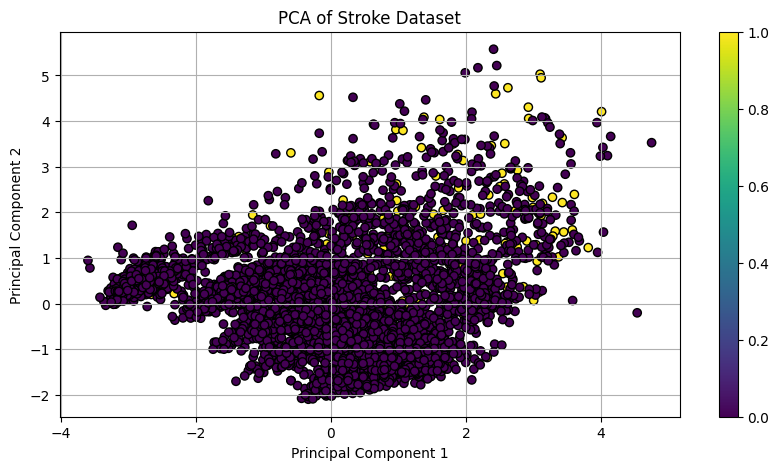

In [39]:
# Initialize PCA
pca = PCA(n_components=2)  # Number of components: 2

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Plot the data points in the new 2D space
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Stroke Dataset')
plt.grid(True)
plt.colorbar()
plt.show()

In [40]:
# Reconstruction of the original data
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate the reconstruction error
reconstruction_error = np.square(X - X_reconstructed).mean()
print("Reconstruction error:\n", reconstruction_error)

Reconstruction error:
 gender               0.237003
age                  0.389844
hypertension         0.678731
heart_disease        0.636025
ever_married         0.147513
work_type            0.930160
Residence_type       0.249825
avg_glucose_level    0.604619
bmi                  0.680650
smoking_status       0.323328
dtype: float64


## Feature importance analysis

In [55]:
# Run the permutation importance 10 times
result = permutation_importance(svc_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

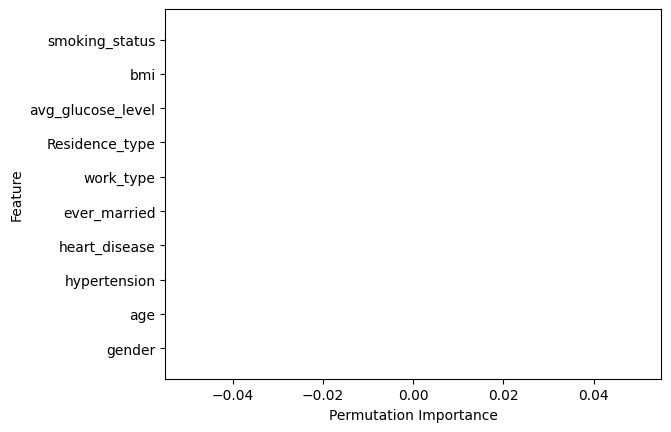

In [43]:
# Get column names from the original data
column_names = X.columns

# Extract importance scores and their standard deviations
sorted_idx = result.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [column_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.show()

## Effect of dataset size on performance (learning curves)

In [ ]:
# Define the model
model = SVC(kernel="linear", probability=True)

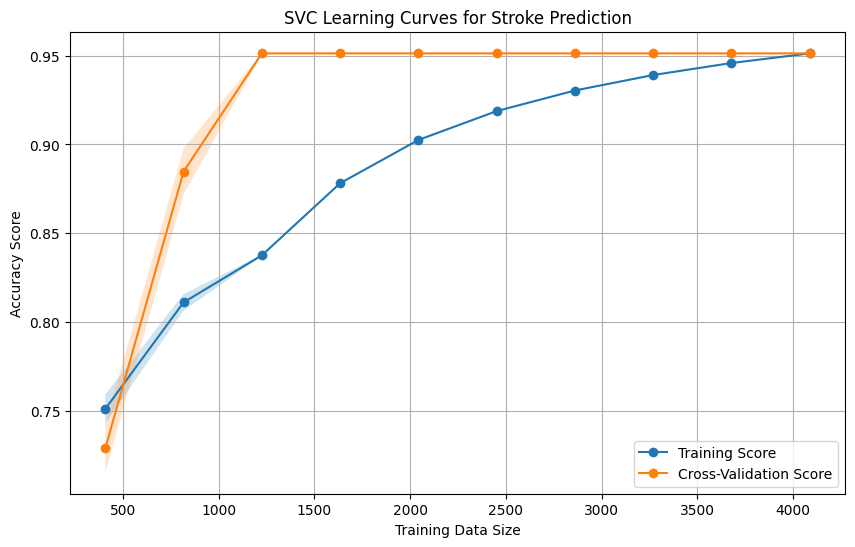

In [45]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model,  # Test the performance of the SVC model
    X,  # Features
    y,  # Target
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    train_sizes=np.linspace(0.1, 1.0, 10))  # 10 different sizes of the training set

# Calculate the mean and standard deviation for training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.title('SVC Learning Curves for Stroke Prediction')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [52]:
model = SVC(kernel="rbf",  # RBF kernel
            probability=True)

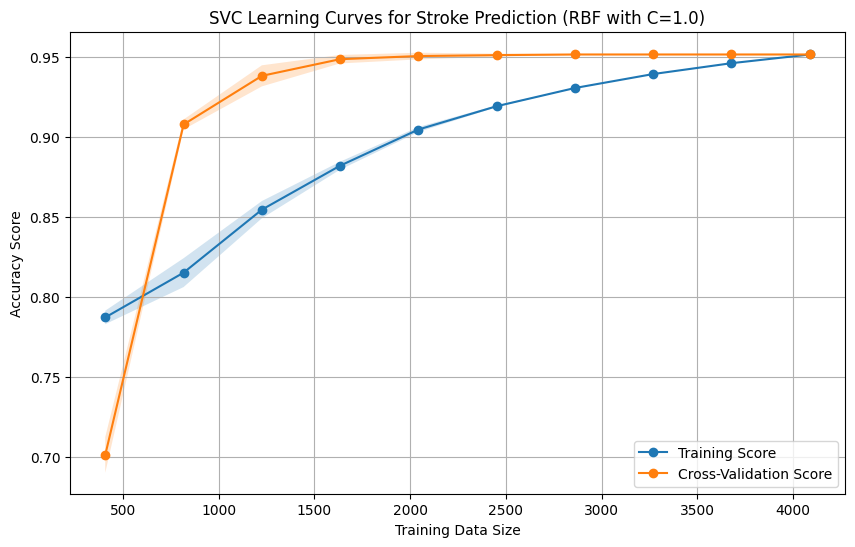

In [53]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model,  # Test the performance of the SVC model
    X,  # Features
    y,  # Target
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    train_sizes=np.linspace(0.1, 1.0, 10))  # 10 different sizes of the training set

# Calculate the mean and standard deviation for training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.title('SVC Learning Curves for Stroke Prediction (RBF with C=1.0)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
model = SVC(kernel="rbf",
            probability=True,
            C=0.01)  # Regularization parameter

In [ ]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model,  # Test the performance of the SVC model
    X,  # Features
    y,  # Target
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    train_sizes=np.linspace(0.1, 1.0, 10))  # 10 different sizes of the training set

# Calculate the mean and standard deviation for training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.title('SVC Learning Curves for Stroke Prediction (RBF with C=1.0)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Cluster analysis

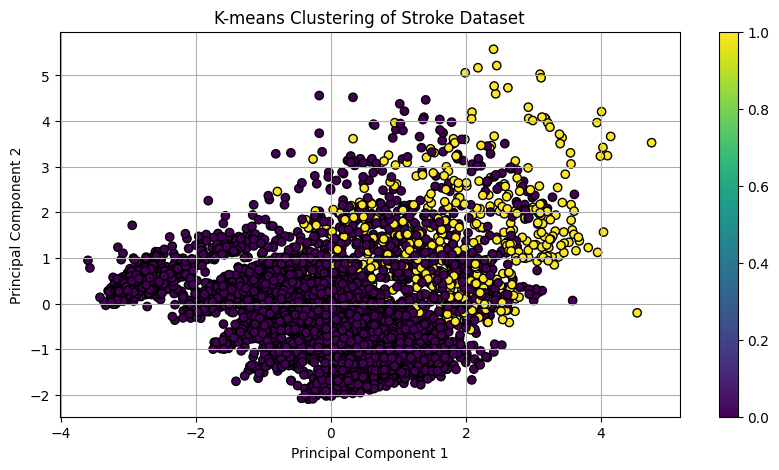

In [54]:
# k-means clustering
kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)  # 2 clusters
kmeans.fit(X)

# Get cluster assignments
clusters = kmeans.predict(X)

# Plot the data points in the new 2D space
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Stroke Dataset')
plt.grid(True)
plt.colorbar()
plt.show()